
Annual Returns:
TSLA    1.012083
BND     1.784610
SPY     1.106191
dtype: float64

Annualized Covariance Matrix:
          TSLA       BND       SPY
TSLA  1.157969 -0.075340  0.498145
BND  -0.075340  8.583302 -0.341487
SPY   0.498145 -0.341487  2.156064

Correlation Matrix:
          TSLA       BND       SPY
TSLA  1.000000 -0.023897  0.315266
BND  -0.023897  1.000000 -0.079381
SPY   0.315266 -0.079381  1.000000

Initial Portfolio Weights:
TSLA: 0.33
BND: 0.33
SPY: 0.33

Portfolio Annual Return: 1.3010
Portfolio Annual Volatility: 1.1576
Portfolio Sharpe Ratio: 1.1152

Annualized Statistics for Each Asset:
TSLA: Return=1.0121, Volatility=1.0761, Sharpe Ratio=0.9312
BND: Return=1.7846, Volatility=2.9297, Sharpe Ratio=0.6057
SPY: Return=1.1062, Volatility=1.4684, Sharpe Ratio=0.7465


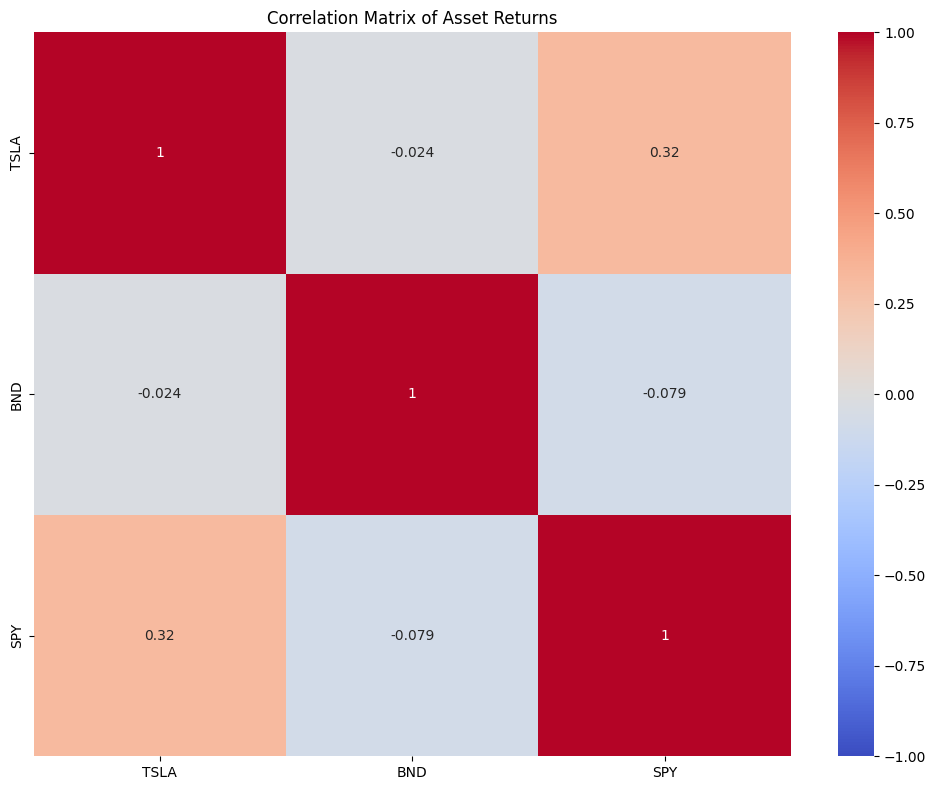

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('C:/Users/neba/Desktop/finance_forecasting_project/data/processed/processed_financial_data.csv')

# Step 1: Combine closing prices into one DataFrame
df = pd.DataFrame({
    'Date': data['Date'],
    'TSLA': data['TSLA_Close'],
    'BND': data['BND_Close'],
    'SPY': data['SPY_Close']
})

# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Handle NaNs first
df = df.replace(0, np.nan) #replace zeros with nan, if they are errors.
df = df.dropna()  # Or use fillna or interpolate instead of dropna

# Step 2: Calculate daily returns with proper handling
returns = df.pct_change().dropna()

# Check for infinite values and replace them
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna()

# Step 3: Calculate annual returns (252 trading days in a year)
annual_returns = returns.mean() * 252
print("\nAnnual Returns:")
print(annual_returns)

# Step 4: Calculate covariance matrix (annualized)
cov_matrix = returns.cov() * 252
print("\nAnnualized Covariance Matrix:")
print(cov_matrix)

# Step 5: Calculate correlation matrix
corr_matrix = returns.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Asset Returns')
plt.tight_layout()

# Initial portfolio with equal weights
weights = np.array([1/3, 1/3, 1/3])  # Equal allocation to TSLA, BND, SPY
print("\nInitial Portfolio Weights:")
for asset, weight in zip(df.columns, weights):
    print(f"{asset}: {weight:.2f}")

# Calculate portfolio return
portfolio_return = np.sum(weights * annual_returns)
print(f"\nPortfolio Annual Return: {portfolio_return:.4f}")

# Calculate portfolio volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
print(f"Portfolio Annual Volatility: {portfolio_volatility:.4f}")

# Calculate Sharpe Ratio (assuming risk-free rate of 0.01 or 1%)
risk_free_rate = 0.01
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")

# Calculate annualized returns for each asset
print("\nAnnualized Statistics for Each Asset:")
for asset in df.columns:
    asset_return = annual_returns[asset]
    asset_vol = np.sqrt(cov_matrix.loc[asset, asset])
    asset_sharpe = (asset_return - risk_free_rate) / asset_vol
    print(f"{asset}: Return={asset_return:.4f}, Volatility={asset_vol:.4f}, Sharpe Ratio={asset_sharpe:.4f}")

Optimal Portfolio Weights:
TSLA: 0.8406
BND: 0.0469
SPY: 0.1126

Optimized Portfolio Annual Return: 241.1516
Optimized Portfolio Annual Volatility: 439.6706
Optimized Portfolio Sharpe Ratio: 0.5485

Value at Risk (VaR) Analysis:
1-Day VaR (95%) for TSLA: 8.4389%
1-Day VaR (95%) for BND: 7.8984%
1-Day VaR (95%) for SPY: 5.8486%
1-Day VaR (95%) for Optimized Portfolio: 7.5340%
10-Day VaR (95%) for Optimized Portfolio: 23.8246%


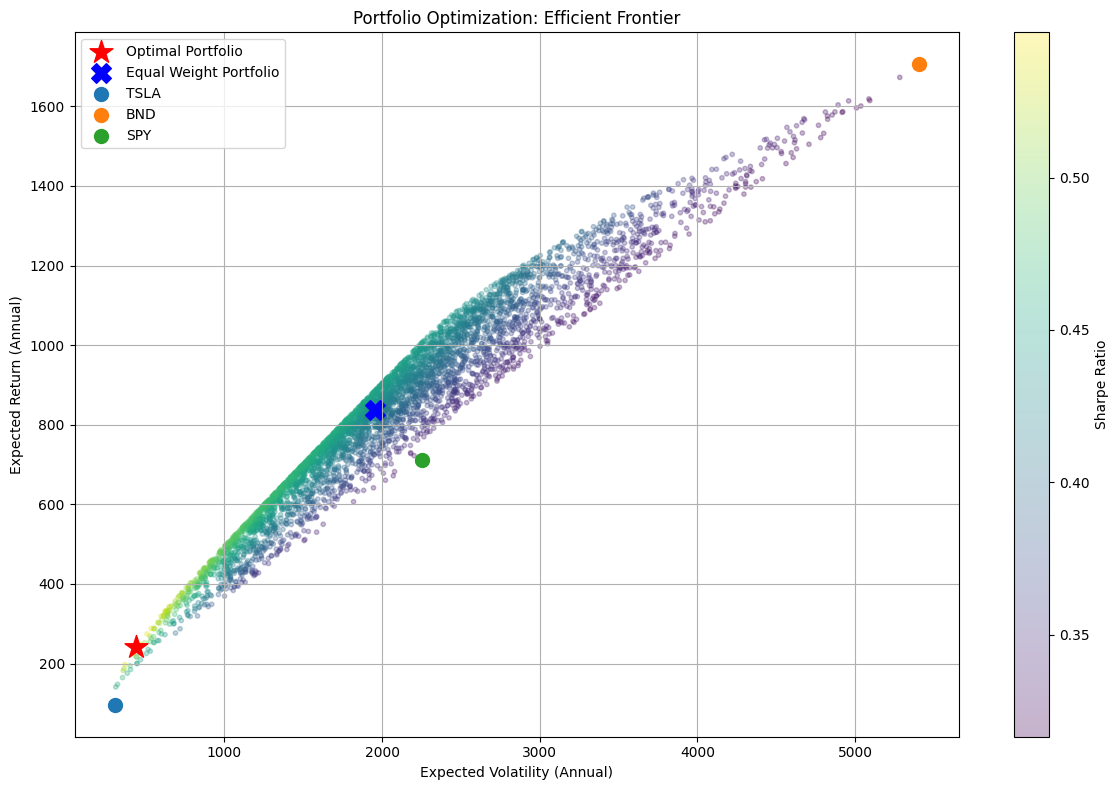

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('C:/Users/neba/Desktop/finance_forecasting_project/data/processed/processed_financial_data.csv')

# Step 1: Combine closing prices into one DataFrame
df = pd.DataFrame({
    'Date': data['Date'],
    'TSLA': data['TSLA_Close'],
    'BND': data['BND_Close'],
    'SPY': data['SPY_Close']
})

# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Handle NaNs first
df = df.replace(0, np.nan)  # replace zeros with nan, if they are errors.
df = df.dropna()  # Or use fillna or interpolate instead of dropna

# Step 2: Calculate daily returns with proper handling
returns = df.pct_change().dropna()

# Check for infinite values and replace them
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna()

# Step 3: Calculate annual returns (252 trading days in a year)
annual_returns = returns.mean() * 252

# Step 4: Calculate covariance matrix (annualized)
cov_matrix = returns.cov() * 252

# Risk-free rate
risk_free_rate = 0.01

# --- Portfolio Optimization Functions ---
def portfolio_return(weights, returns):
    return np.sum(returns * weights)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (portfolio_return(weights, returns) - risk_free_rate) / portfolio_volatility(weights, cov_matrix)

def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# --- Maximum Sharpe Ratio Optimization ---
initial_weights = np.array([1 / len(df.columns)] * len(df.columns))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(df.columns)))

optimal_sharpe_results = minimize(neg_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, risk_free_rate),
                                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_sharpe_weights = optimal_sharpe_results.x

print("\n--- Maximum Sharpe Ratio Optimization ---")
print("Optimal Weights:", dict(zip(df.columns, optimal_sharpe_weights)))
print("Optimal Return:", portfolio_return(optimal_sharpe_weights, annual_returns))
print("Optimal Volatility:", portfolio_volatility(optimal_sharpe_weights, cov_matrix))
print("Optimal Sharpe Ratio:", sharpe_ratio(optimal_sharpe_weights, annual_returns, cov_matrix, risk_free_rate))

# --- Minimum Volatility Optimization ---
min_vol_results = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,), method='SLSQP',
                            bounds=bounds, constraints=constraints)
min_vol_weights = min_vol_results.x

print("\n--- Minimum Volatility Optimization ---")
print("Optimal Weights:", dict(zip(df.columns, min_vol_weights)))
print("Optimal Return:", portfolio_return(min_vol_weights, annual_returns))
print("Optimal Volatility:", portfolio_volatility(min_vol_weights, cov_matrix))
print("Optimal Sharpe Ratio:", sharpe_ratio(min_vol_weights, annual_returns, cov_matrix, risk_free_rate))

# --- Efficient Frontier Analysis ---
num_portfolios = 5000
results = np.zeros((num_portfolios, 3))
weights_record = []

for i in range(num_portfolios):
    w = np.random.random(len(df.columns))
    w = w / np.sum(w)
    weights_record.append(w)
    port_return = portfolio_return(w, annual_returns)
    port_volatility = portfolio_volatility(w, cov_matrix)
    port_sharpe = sharpe_ratio(w, annual_returns, cov_matrix, risk_free_rate)
    results[i, :] = [port_return, port_volatility, port_sharpe]

results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe'])

# Plot Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df.Volatility, results_df.Return, c=results_df.Sharpe, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility(optimal_sharpe_weights, cov_matrix), portfolio_return(optimal_sharpe_weights, annual_returns), c='red', marker='*', s=300, label='Max Sharpe')
plt.scatter(portfolio_volatility(min_vol_weights, cov_matrix), portfolio_return(min_vol_weights, annual_returns), c='blue', marker='*', s=300, label='Min Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Maximum Sharpe Ratio Optimization ---
Optimal Weights: {'TSLA': np.float64(0.5417304336980038), 'BND': np.float64(0.1723099985104232), 'SPY': np.float64(0.285959567791573)}
Optimal Return: 1.1721081966820008
Optimal Volatility: 0.9368051125772895
Optimal Sharpe Ratio: 1.2405015526493757

--- Minimum Volatility Optimization ---
Optimal Weights: {'TSLA': np.float64(0.620560127806022), 'BND': np.float64(0.11418411599061747), 'SPY': np.float64(0.2652557562033606)}
Optimal Return: 1.1252560150513617
Optimal Volatility: 0.917699798036631
Optimal Sharpe Ratio: 1.215273248874405


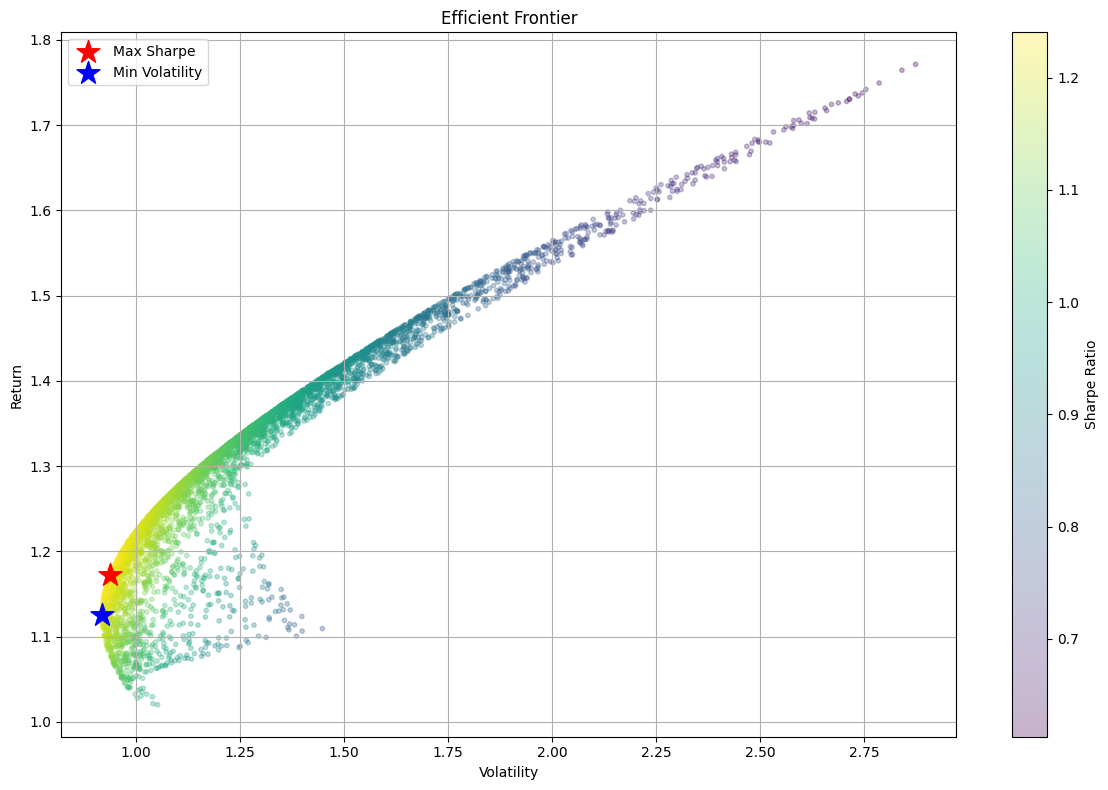

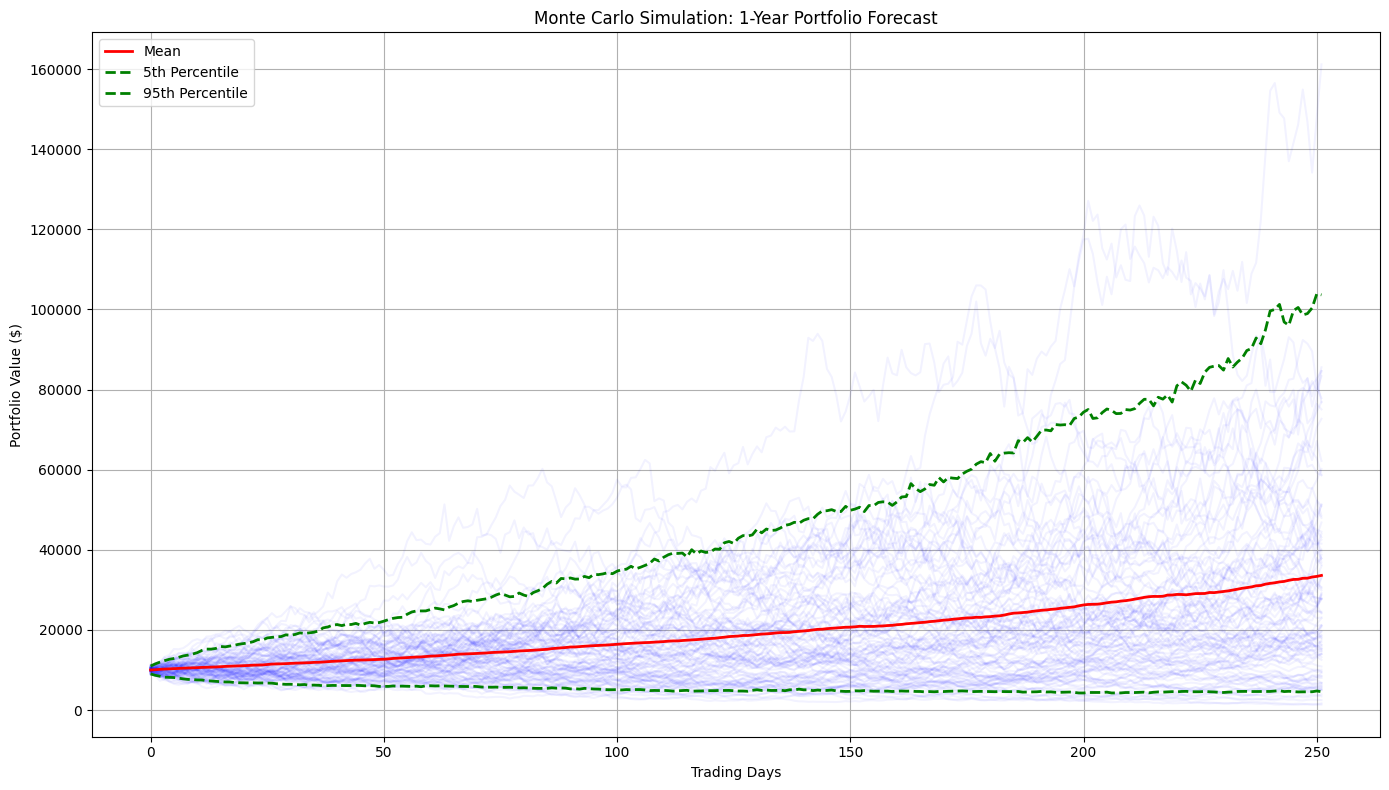

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('C:/Users/neba/Desktop/finance_forecasting_project/data/processed/processed_financial_data.csv')

# Step 1: Combine closing prices into one DataFrame
df = pd.DataFrame({
    'Date': data['Date'],
    'TSLA': data['TSLA_Close'],
    'BND': data['BND_Close'],
    'SPY': data['SPY_Close']
})

# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Handle NaNs first
df = df.replace(0, np.nan)
df = df.dropna()

# Step 2: Calculate daily returns with proper handling
returns = df.pct_change().dropna()
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna()

# Step 3: Calculate annual returns (252 trading days in a year)
annual_returns = returns.mean() * 252

# Step 4: Calculate covariance matrix (annualized)
cov_matrix = returns.cov() * 252

# Risk-free rate
risk_free_rate = 0.01

# --- Portfolio Optimization Functions ---
def portfolio_return(weights, returns):
    return np.sum(returns * weights)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (portfolio_return(weights, returns) - risk_free_rate) / portfolio_volatility(weights, cov_matrix)

def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# --- Maximum Sharpe Ratio Optimization ---
initial_weights = np.array([1 / len(df.columns)] * len(df.columns))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(df.columns)))

optimal_sharpe_results = minimize(neg_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, risk_free_rate),
                                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_sharpe_weights = optimal_sharpe_results.x

print("\n--- Maximum Sharpe Ratio Optimization ---")
print("Optimal Weights:", dict(zip(df.columns, optimal_sharpe_weights)))
print("Optimal Return:", portfolio_return(optimal_sharpe_weights, annual_returns))
print("Optimal Volatility:", portfolio_volatility(optimal_sharpe_weights, cov_matrix))
print("Optimal Sharpe Ratio:", sharpe_ratio(optimal_sharpe_weights, annual_returns, cov_matrix, risk_free_rate))

# --- Minimum Volatility Optimization ---
min_vol_results = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,), method='SLSQP',
                            bounds=bounds, constraints=constraints)
min_vol_weights = min_vol_results.x

print("\n--- Minimum Volatility Optimization ---")
print("Optimal Weights:", dict(zip(df.columns, min_vol_weights)))
print("Optimal Return:", portfolio_return(min_vol_weights, annual_returns))
print("Optimal Volatility:", portfolio_volatility(min_vol_weights, cov_matrix))
print("Optimal Sharpe Ratio:", sharpe_ratio(min_vol_weights, annual_returns, cov_matrix, risk_free_rate))

# --- Efficient Frontier Analysis ---
num_portfolios = 5000
results = np.zeros((num_portfolios, 3))
weights_record = []

for i in range(num_portfolios):
    w = np.random.random(len(df.columns))
    w = w / np.sum(w)
    weights_record.append(w)
    port_return = portfolio_return(w, annual_returns)
    port_volatility = portfolio_volatility(w, cov_matrix)
    port_sharpe = sharpe_ratio(w, annual_returns, cov_matrix, risk_free_rate)
    results[i, :] = [port_return, port_volatility, port_sharpe]

results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe'])

# Plot Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df.Volatility, results_df.Return, c=results_df.Sharpe, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility(optimal_sharpe_weights, cov_matrix), portfolio_return(optimal_sharpe_weights, annual_returns), c='red', marker='*', s=300, label='Max Sharpe')
plt.scatter(portfolio_volatility(min_vol_weights, cov_matrix), portfolio_return(min_vol_weights, annual_returns), c='blue', marker='*', s=300, label='Min Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Monte Carlo Simulation ---
mean_returns = returns.mean()
days = 252  # 1 trading year
num_simulations = 1000
initial_value = 10000  # $10,000 investment
return_matrix = np.zeros((days, num_simulations))

for sim in range(num_simulations):
    sim_returns = np.random.multivariate_normal(mean_returns, returns.cov(), days)
    portfolio_sim_returns = np.sum(sim_returns * optimal_sharpe_weights, axis=1)
    return_matrix[:, sim] = initial_value * (1 + portfolio_sim_returns).cumprod()

plt.figure(figsize=(14, 8))
for i in range(100):
    plt.plot(return_matrix[:, i], 'b-', alpha=0.05)
plt.plot(return_matrix.mean(axis=1), 'r-', linewidth=2, label='Mean')
plt.plot(np.percentile(return_matrix, 5, axis=1), 'g--', linewidth=2, label='5th Percentile')
plt.plot(np.percentile(return_matrix, 95, axis=1), 'g--', linewidth=2, label='95th Percentile')
plt.title('Monte Carlo Simulation: 1-Year Portfolio Forecast')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

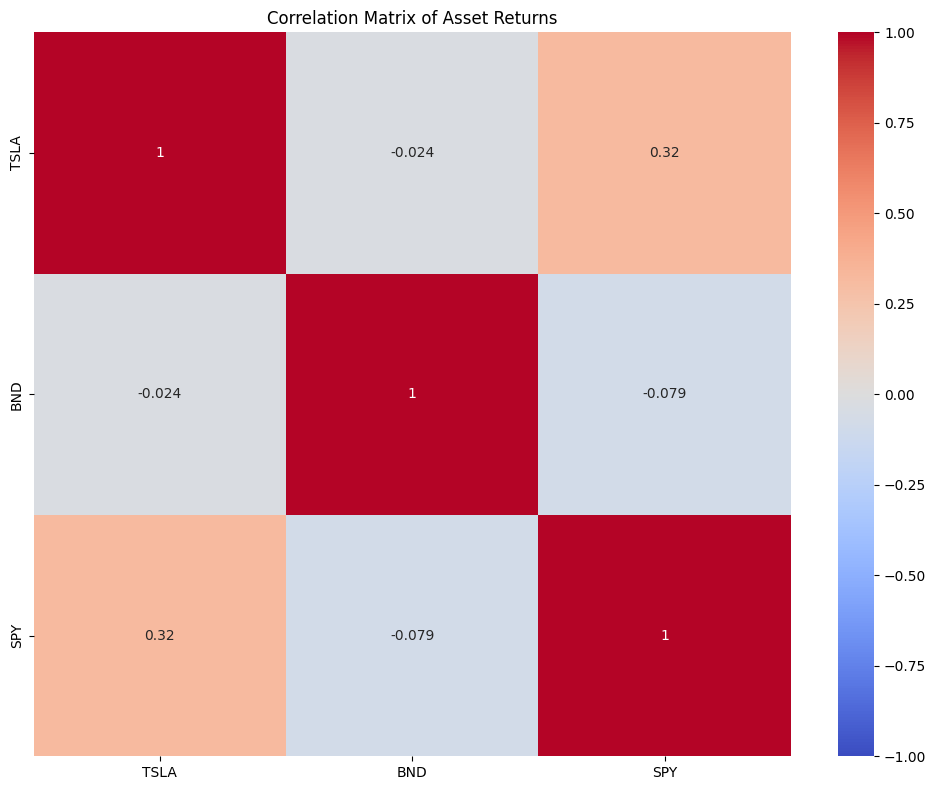

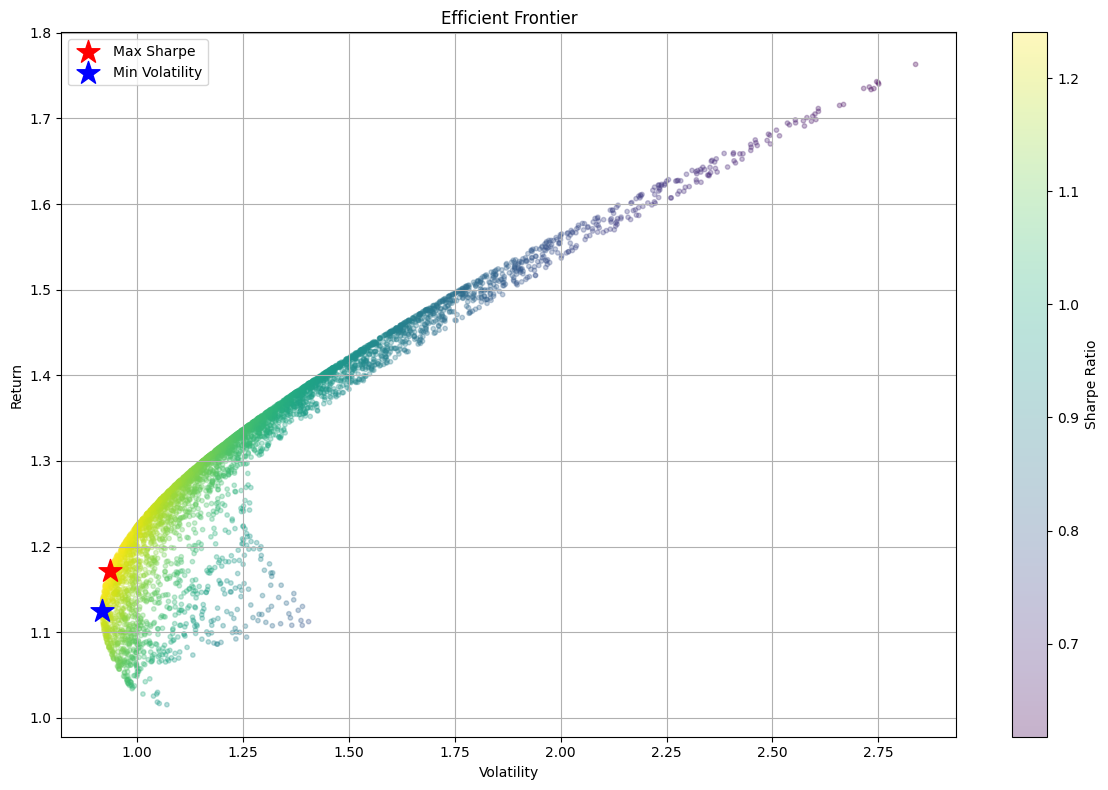

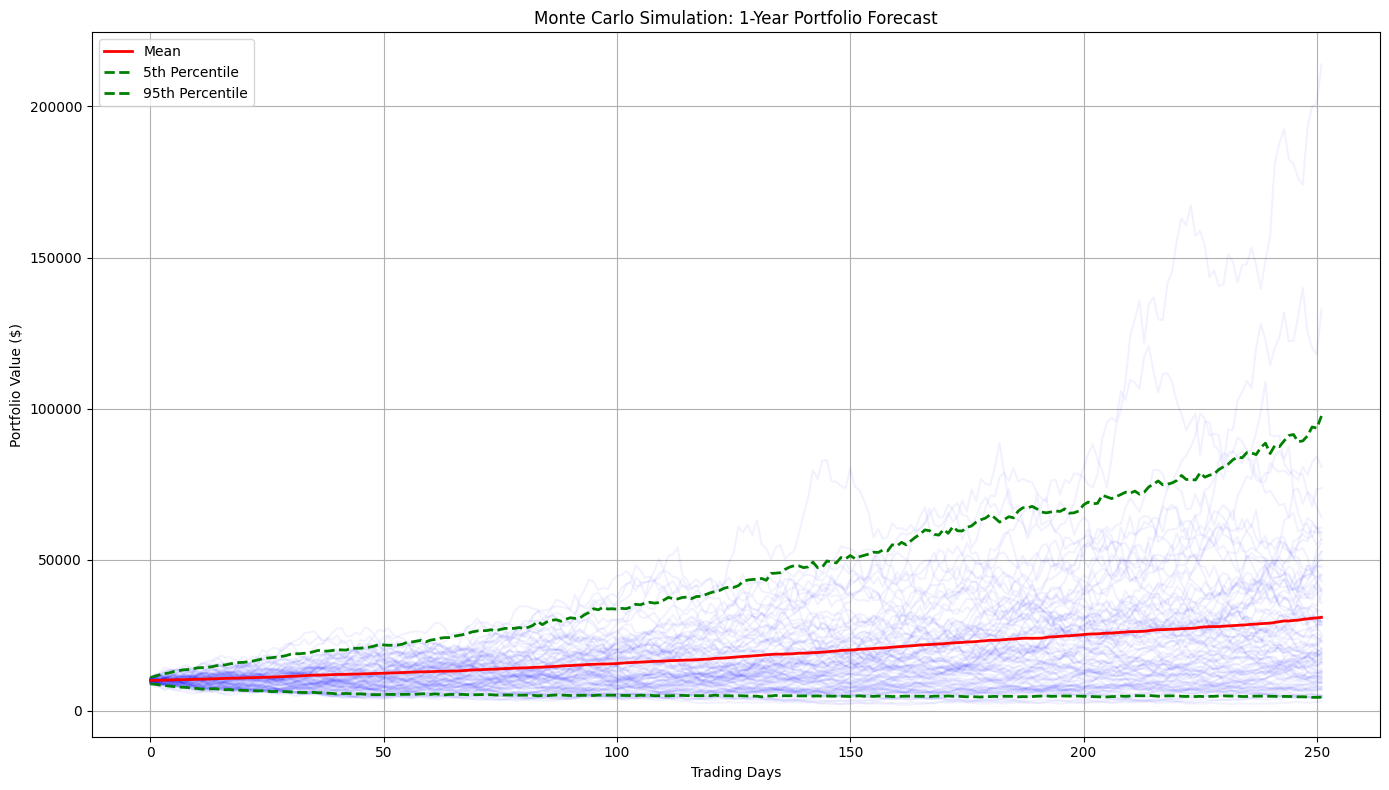

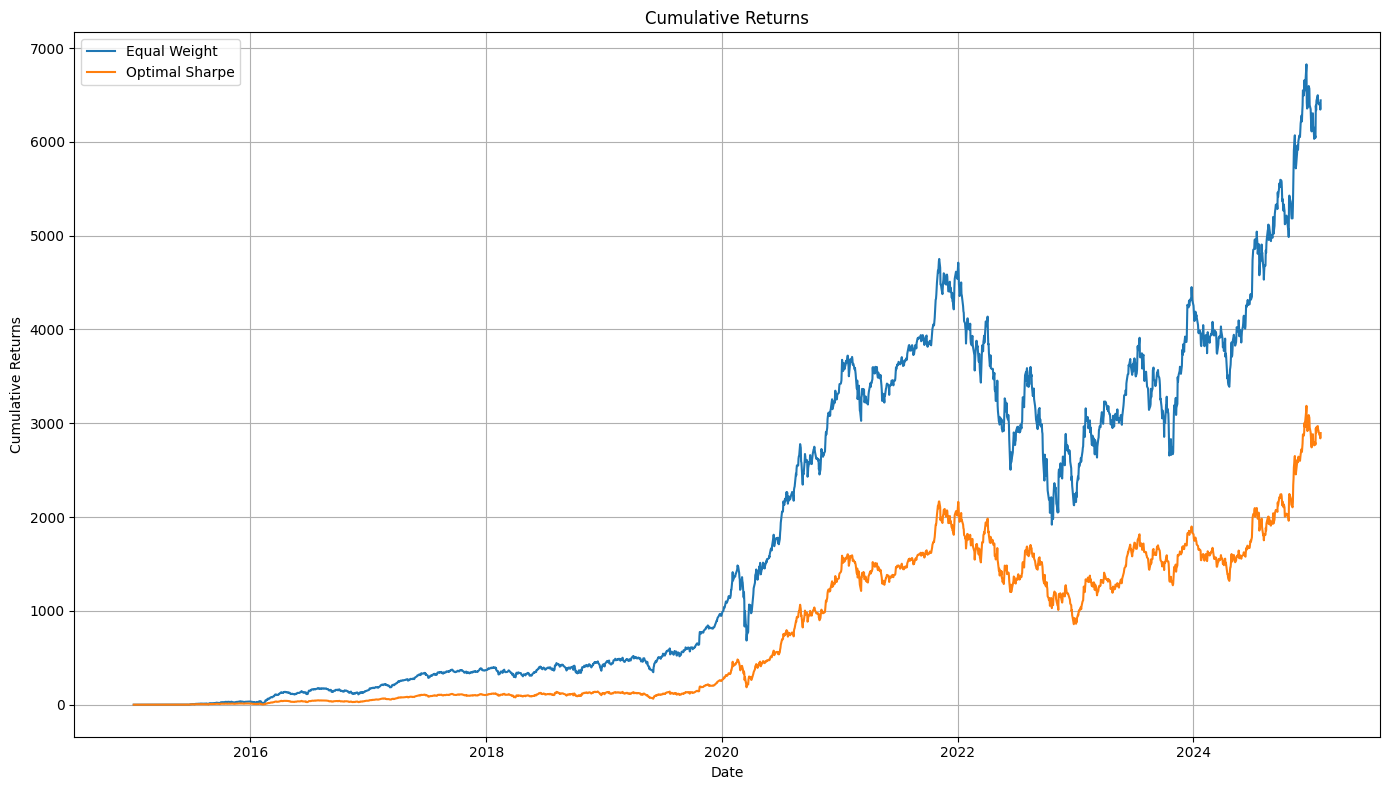

1-Day VaR (95%) for TSLA: 8.4257%
1-Day VaR (95%) for Optimized Portfolio: 5.8434%


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import seaborn as sns  # For correlation matrix heatmap

warnings.filterwarnings('ignore')

data = pd.read_csv('C:/Users/neba/Desktop/finance_forecasting_project/data/processed/processed_financial_data.csv')

# Step 1: Combine closing prices into one DataFrame
df = pd.DataFrame({
    'Date': data['Date'],
    'TSLA': data['TSLA_Close'],
    'BND': data['BND_Close'],
    'SPY': data['SPY_Close']
})

# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Handle NaNs first
df = df.replace(0, np.nan)
df = df.dropna()

# Step 2: Calculate daily returns with proper handling
returns = df.pct_change().dropna()
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna()

# Step 3: Calculate annual returns (252 trading days in a year)
annual_returns = returns.mean() * 252

# Step 4: Calculate covariance matrix (annualized)
cov_matrix = returns.cov() * 252

# Risk-free rate
risk_free_rate = 0.01

# --- Portfolio Optimization Functions ---
def portfolio_return(weights, returns):
    return np.sum(returns * weights)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (portfolio_return(weights, returns) - risk_free_rate) / portfolio_volatility(weights, cov_matrix)

def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# --- Maximum Sharpe Ratio Optimization ---
initial_weights = np.array([1 / len(df.columns)] * len(df.columns))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(df.columns)))

optimal_sharpe_results = minimize(neg_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, risk_free_rate),
                                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_sharpe_weights = optimal_sharpe_results.x

# --- Minimum Volatility Optimization ---
min_vol_results = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,), method='SLSQP',
                            bounds=bounds, constraints=constraints)
min_vol_weights = min_vol_results.x

# --- Efficient Frontier Analysis ---
num_portfolios = 5000
results = np.zeros((num_portfolios, 3))
weights_record = []

for i in range(num_portfolios):
    w = np.random.random(len(df.columns))
    w = w / np.sum(w)
    weights_record.append(w)
    port_return = portfolio_return(w, annual_returns)
    port_volatility = portfolio_volatility(w, cov_matrix)
    port_sharpe = sharpe_ratio(w, annual_returns, cov_matrix, risk_free_rate)
    results[i, :] = [port_return, port_volatility, port_sharpe]

results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe'])

# --- Monte Carlo Simulation ---
mean_returns = returns.mean()
days = 252  # 1 trading year
num_simulations = 1000
initial_value = 10000  # $10,000 investment
return_matrix = np.zeros((days, num_simulations))

for sim in range(num_simulations):
    sim_returns = np.random.multivariate_normal(mean_returns, returns.cov(), days)
    portfolio_sim_returns = np.sum(sim_returns * optimal_sharpe_weights, axis=1)
    return_matrix[:, sim] = initial_value * (1 + portfolio_sim_returns).cumprod()

# --- Visualization ---

# Correlation Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Asset Returns')
plt.tight_layout()
plt.show()

# Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df.Volatility, results_df.Return, c=results_df.Sharpe, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility(optimal_sharpe_weights, cov_matrix), portfolio_return(optimal_sharpe_weights, annual_returns), c='red', marker='*', s=300, label='Max Sharpe')
plt.scatter(portfolio_volatility(min_vol_weights, cov_matrix), portfolio_return(min_vol_weights, annual_returns), c='blue', marker='*', s=300, label='Min Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Monte Carlo Simulation
plt.figure(figsize=(14, 8))
for i in range(100):
    plt.plot(return_matrix[:, i], 'b-', alpha=0.05)
plt.plot(return_matrix.mean(axis=1), 'r-', linewidth=2, label='Mean')
plt.plot(np.percentile(return_matrix, 5, axis=1), 'g--', linewidth=2, label='5th Percentile')
plt.plot(np.percentile(return_matrix, 95, axis=1), 'g--', linewidth=2, label='95th Percentile')
plt.title('Monte Carlo Simulation: 1-Year Portfolio Forecast')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cumulative Returns
equal_weights = np.array([1/len(df.columns)]*len(df.columns))
equal_portfolio_returns = returns.dot(equal_weights)
optimal_portfolio_returns = returns.dot(optimal_sharpe_weights)
equal_cumulative = (1 + equal_portfolio_returns).cumprod()
optimal_cumulative = (1 + optimal_portfolio_returns).cumprod()
plt.figure(figsize=(14,8))
plt.plot(equal_cumulative.index, equal_cumulative, label="Equal Weight")
plt.plot(optimal_cumulative.index, optimal_cumulative, label = "Optimal Sharpe")
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

confidence_level = 0.95
# For Tesla VaR
tesla_returns = returns['TSLA']
tesla_var = -np.percentile(tesla_returns, 100 * (1 - confidence_level)) * 100
print(f"1-Day VaR ({confidence_level:.0%}) for TSLA: {tesla_var:.4f}%")

# For optimized portfolio VaR
portfolio_returns = returns.dot(optimal_sharpe_weights)
portfolio_var = -np.percentile(portfolio_returns, 100 * (1 - confidence_level)) * 100
print(f"1-Day VaR ({confidence_level:.0%}) for Optimized Portfolio: {portfolio_var:.4f}%")